In [1]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
import shap

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")


In [3]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [5]:
clf_full_period = DecisionTreeClassifier(random_state=10, class_weight="balanced")


In [19]:
weeks_to_predict = [10]

for prediction_week in weeks_to_predict:
    print(prediction_week)
    no_weeks_train = range(1, int(prediction_week + train_weeks_for_initial_model) + 1)
    no_weeks_test = range(
        int(prediction_week + train_weeks_for_initial_model) + 1,
        int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1,
    )
    (
        X_train_full_period,
        y_train_full_period,
        weights_full_period,
        missing_data_train_HSA,
    ) = prep_training_test_data(
        HSA_weekly_data_all,
        no_weeks=no_weeks_train,
        weeks_in_future=3,
        geography="HSA_ID",
        weight_col="weight",
        keep_output=keep_output,
    )

    (
        X_test_full_period,
        y_test_full_period,
        weights_test_full_period,
        missing_data_test_HSA,
    ) = prep_training_test_data(
        HSA_weekly_data_all,
        no_weeks=no_weeks_test,
        weeks_in_future=3,
        geography="HSA_ID",
        weight_col="weight",
        keep_output=keep_output,
    )
    
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(
        HSA_weekly_data_all,
        geography_column=geography_column,
        geo_split=geo_split,
        no_iterations=no_iterations,
        cv=cv,
        classifier=clf_full_period,
        param_grid=param_grid,
        no_iterations_param=no_iterations_param,
        no_weeks_train=no_weeks_train,
        no_weeks_test=no_weeks_test,
        weeks_in_future=weeks_in_future,
        weight_col=weight_col,
        keep_output=keep_output,
        time_period=time_period,
    )

    clf_full_period.fit(
        X_train_full_period, y_train_full_period, sample_weight=weights_full_period
    )

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(
        roc_auc_score(y_test_full_period, y_pred_proba[:, 1])
    )
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    model_name_to_save = (
        "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    )

    #pickle.dump(clf_full_period, open(model_name_to_save, "wb"))
    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(sensitvity)
    norm_MCC_by_week_full_period.append(
        (matthews_corrcoef(y_test_full_period, y_pred) + 1) / 2
    )

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)
    print(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))


10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.7878014842300556


Number of nodes in the last tree is: 3 with ccp_alpha: 0.20866293189880186


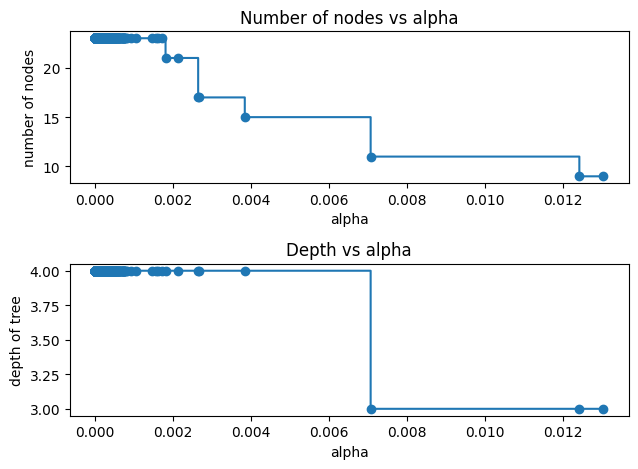

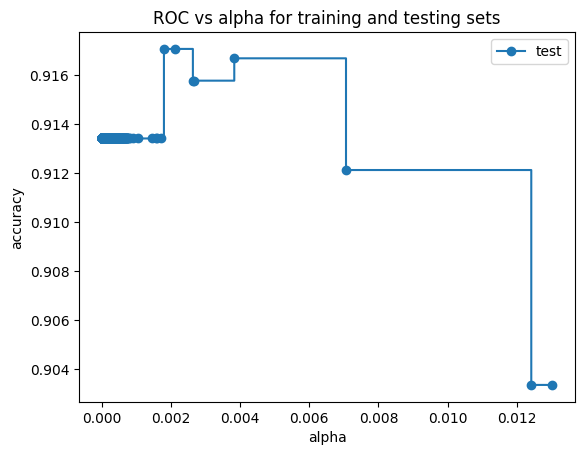

In [22]:
path = clf_full_period.cost_complexity_pruning_path(X_train_full_period, y_train_full_period)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**best_params,random_state=10, ccp_alpha=ccp_alpha,  class_weight='balanced')
    clf.fit(X_train_full_period, y_train_full_period)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]



train_scores_roc = [roc_auc_score(y_train_full_period, clf.predict_proba(X_train_full_period)[:, 1]) for clf in clfs]
test_scores_roc = [roc_auc_score(y_test_full_period, clf.predict_proba(X_test_full_period)[:, 1]) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("ROC vs alpha for training and testing sets")
#ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_roc, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()


In [6]:
no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'ccp_alpha': np.arange(0.0001, 0.005, 0.0001) }


weeks_to_predict = [10]
for prediction_week in weeks_to_predict:
    print(prediction_week)
    no_weeks_train = range(1, int(prediction_week + train_weeks_for_initial_model) + 1)
    no_weeks_test = range(
        int(prediction_week + train_weeks_for_initial_model) + 1,
        int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1,
    )
    (
        X_train_full_period,
        y_train_full_period,
        weights_full_period,
        missing_data_train_HSA,
    ) = prep_training_test_data(
        HSA_weekly_data_all,
        no_weeks=no_weeks_train,
        weeks_in_future=3,
        geography="HSA_ID",
        weight_col="weight",
        keep_output=keep_output,
    )

    (
        X_test_full_period,
        y_test_full_period,
        weights_test_full_period,
        missing_data_test_HSA,
    ) = prep_training_test_data(
        HSA_weekly_data_all,
        no_weeks=no_weeks_test,
        weeks_in_future=3,
        geography="HSA_ID",
        weight_col="weight",
        keep_output=keep_output,
    )
    
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(
        HSA_weekly_data_all,
        geography_column=geography_column,
        geo_split=geo_split,
        no_iterations=no_iterations,
        cv=cv,
        classifier=clf_full_period,
        param_grid=param_grid,
        no_iterations_param=no_iterations_param,
        no_weeks_train=no_weeks_train,
        no_weeks_test=no_weeks_test,
        weeks_in_future=weeks_in_future,
        weight_col=weight_col,
        keep_output=keep_output,
        time_period=time_period,
    )

    clf_full_period.fit(
        X_train_full_period, y_train_full_period, sample_weight=weights_full_period
    )

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(
        roc_auc_score(y_test_full_period, y_pred_proba[:, 1])
    )
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    model_name_to_save = (
        "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    )

    #pickle.dump(clf_full_period, open(model_name_to_save, "wb"))
    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(sensitvity)
    norm_MCC_by_week_full_period.append(
        (matthews_corrcoef(y_test_full_period, y_pred) + 1) / 2
    )

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


NameError: name 'accuracy_by_week_full_period' is not defined

In [11]:
ROC_by_week_full_period

[0.7878014842300556]

In [20]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1)}
 #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [ ]:
weeks_to_predict = [10]

for prediction_week in weeks_to_predict:
    print(prediction_week)
    no_weeks_train = range(1, int(prediction_week + train_weeks_for_initial_model) + 1)
    no_weeks_test = range(
        int(prediction_week + train_weeks_for_initial_model) + 1,
        int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1,
    )
    (
        X_train_full_period,
        y_train_full_period,
        weights_full_period,
        missing_data_train_HSA,
    ) = prep_training_test_data(
        HSA_weekly_data_all,
        no_weeks=no_weeks_train,
        weeks_in_future=3,
        geography="HSA_ID",
        weight_col="weight",
        keep_output=keep_output,
    )

    (
        X_test_full_period,
        y_test_full_period,
        weights_test_full_period,
        missing_data_test_HSA,
    ) = prep_training_test_data(
        HSA_weekly_data_all,
        no_weeks=no_weeks_test,
        weeks_in_future=3,
        geography="HSA_ID",
        weight_col="weight",
        keep_output=keep_output,
    )
    
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(
        HSA_weekly_data_all,
        geography_column=geography_column,
        geo_split=geo_split,
        no_iterations=no_iterations,
        cv=cv,
        classifier=clf_full_period,
        param_grid=param_grid,
        no_iterations_param=no_iterations_param,
        no_weeks_train=no_weeks_train,
        no_weeks_test=no_weeks_test,
        weeks_in_future=weeks_in_future,
        weight_col=weight_col,
        keep_output=keep_output,
        time_period=time_period,
    )

    clf_full_period.fit(
        X_train_full_period, y_train_full_period, sample_weight=weights_full_period
    )

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(
        roc_auc_score(y_test_full_period, y_pred_proba[:, 1])
    )
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    model_name_to_save = (
        "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    )

    #pickle.dump(clf_full_period, open(model_name_to_save, "wb"))
    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(sensitvity)
    norm_MCC_by_week_full_period.append(
        (matthews_corrcoef(y_test_full_period, y_pred) + 1) / 2
    )

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)
    print(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
